# Database Exams Project Neoj4

## Necessary Imports 

In [1]:
# Import necessary libraries
import pandas as pd
from py2neo import Graph
from py2neo import Graph, Node, Relationship
from neo4j import GraphDatabase

C:\Users\jeffo\AppData\Local\Temp\ipykernel_14004\1703840733.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Check for Missing Values and Duplicates

In [31]:
# Check for missing values
print(borough_historical.isnull().sum())

print(lsoa_historical.isnull().sum())

print(ward_historical.isnull().sum())


# Check for duplicates
print(borough_historical.duplicated().sum())

print(lsoa_historical.duplicated().sum())

print(ward_historical.duplicated().sum())



NameError: name 'borough_historical' is not defined

## Inspect Data Types

In [5]:
# Inspect data types
print(borough_historical.dtypes)

print(lsoa_historical.dtypes)

print(ward_historical.dtypes)



MajorText      object
MinorText      object
BoroughName    object
201004          int64
201005          int64
                ...  
202112          int64
202201          int64
202202          int64
202203          int64
202204          int64
Length: 148, dtype: object
MajorText      object
MinorText      object
BoroughName    object
202205          int64
202206          int64
202207          int64
202208          int64
202209          int64
202210          int64
202211          int64
202212          int64
202301          int64
202302          int64
202303          int64
202304          int64
202305          int64
202306          int64
202307          int64
202308          int64
202309          int64
202310          int64
202311          int64
202312          int64
202401          int64
202402          int64
202403          int64
202404          int64
dtype: object
LSOA Code         object
LSOA Name         object
Borough           object
Major Category    object
Minor Category    objec

## Clean Data

Trim any leading or trailing whitespace from string columns.


Convert date columns to a consistent datetime format.

In [6]:
# Function to clean data
def clean_data(df):
    # Trim whitespace from string columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].map(lambda x: x.strip() if isinstance(x, str) else x)
    
    # Convert date columns to datetime format if present
    date_columns = []  # Adjust this list based on actual date column names if any
    for date_col in date_columns:
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    return df

# Clean each DataFrame
borough_historical = clean_data(borough_historical)

lsoa_historical = clean_data(lsoa_historical)

ward_historical = clean_data(ward_historical)


# Verify the cleaned data
print(borough_historical.head())

print(lsoa_historical.head())

print(ward_historical.head())



                   MajorText                        MinorText  \
0  ARSON AND CRIMINAL DAMAGE                            ARSON   
1  ARSON AND CRIMINAL DAMAGE                  CRIMINAL DAMAGE   
2                   BURGLARY  BURGLARY BUSINESS AND COMMUNITY   
3                   BURGLARY           BURGLARY IN A DWELLING   
4              DRUG OFFENCES              POSSESSION OF DRUGS   

            BoroughName  201004  201005  201006  201007  201008  201009  \
0  Barking and Dagenham       6       5      11      10       6       6   
1  Barking and Dagenham     204     190     218     217     203     161   
2  Barking and Dagenham      48      58      58      46      46      51   
3  Barking and Dagenham     116     102     124     137     153     136   
4  Barking and Dagenham      76      64      82      72      98      87   

   201010  ...  202107  202108  202109  202110  202111  202112  202201  \
0      13  ...       3      12       5       7       5       1       3   
1     196 

## Dont USE!!!! Deleting Nodes in Batches

In [12]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"  # Ensure this matches your Neo4j instance
driver = GraphDatabase.driver(uri, auth=("neo4j", "12345678"))

def delete_in_batches(driver, batch_size=1000):
    with driver.session() as session:
        while True:
            result = session.run(f"MATCH (n) WITH n LIMIT {batch_size} DETACH DELETE n RETURN COUNT(n) as count")
            count = result.single()["count"]
            if count == 0:
                break
            print(f"Deleted {count} nodes in this batch.")

delete_in_batches(driver)
print("All nodes and relationships have been deleted.")


Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 1000 nodes in this batch.
Deleted 868 nodes in this batch.
All nodes and relationships have been deleted.


## Dont USE!!!! Deleting Nodes in Batches

Connect to Neo4j

In [43]:
# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12345678"))


Load Data into Pandas DataFrame

In [44]:
# Load Borough Level Crime Data into Pandas DataFrame
borough_data = pd.read_csv('MPS Borough Level Crime (Historical).csv')

# Display the first few rows of the dataframe
print(borough_data.head())


                   MajorText                        MinorText  \
0  ARSON AND CRIMINAL DAMAGE                            ARSON   
1  ARSON AND CRIMINAL DAMAGE                  CRIMINAL DAMAGE   
2                   BURGLARY  BURGLARY BUSINESS AND COMMUNITY   
3                   BURGLARY           BURGLARY IN A DWELLING   
4              DRUG OFFENCES              POSSESSION OF DRUGS   

            BoroughName  201004  201005  201006  201007  201008  201009  \
0  Barking and Dagenham       6       5      11      10       6       6   
1  Barking and Dagenham     204     190     218     217     203     161   
2  Barking and Dagenham      48      58      58      46      46      51   
3  Barking and Dagenham     116     102     124     137     153     136   
4  Barking and Dagenham      76      64      82      72      98      87   

   201010  ...  202107  202108  202109  202110  202111  202112  202201  \
0      13  ...       3      12       5       7       5       1       3   
1     196 

Define Functions for Data Import

Create functions to import the borough data into Neo4j and create relationships.

Function to Load Borough Data

In [25]:
from py2neo import Graph
import pandas as pd

# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12345678"))

# Create constraints for uniqueness
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (b:Borough) REQUIRE b.name IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (c:CrimeIncident) REQUIRE c.id IS UNIQUE")

# Function to load Borough data into Neo4j
def load_borough_data(graph, file_path, row_limit=1000):
    data = pd.read_csv(file_path, nrows=row_limit)  # Load only a subset of rows
    for index, row in data.iterrows():
        # Create or merge Borough nodes
        borough_query = f"""
        MERGE (b:Borough {{name: "{row['BoroughName'].replace('"', '\\"')}"}})
        """
        graph.run(borough_query)

        for year_month in data.columns[5:]:  # Adjust the starting index to match the data columns
            if row[year_month] > 0:
                # Create or merge CrimeIncident nodes and relationships
                crime_query = f"""
                MERGE (c:CrimeIncident {{id: "{row['BoroughName'].replace('"', '\\"')}_{year_month}_{row['MajorText'].replace('"', '\\"')}_{row['MinorText'].replace('"', '\\"')}"}})
                ON CREATE SET c.type = "{row['MajorText'].replace('"', '\\"')}", c.minor_type = "{row['MinorText'].replace('"', '\\"')}", c.date = '{year_month}', c.count = {row[year_month]}
                WITH c
                MATCH (b:Borough {{name: "{row['BoroughName'].replace('"', '\\"')}"}})
                MERGE (c)-[:OCCURRED_AT]->(b)
                """
                graph.run(crime_query)

# Load Borough Data into Neo4j
load_borough_data(graph, 'MPS Borough Level Crime (Historical).csv')


## Verification Queries For Borough Data

In [28]:
# Verification Queries

# Query 1: Count of Boroughs
query_count_boroughs = """
MATCH (b:Borough)
RETURN count(b) AS NumberOfBoroughs
"""

# Query 2: Sample Data from Borough
query_sample_boroughs = """
MATCH (b:Borough)
RETURN b.name AS BoroughName
LIMIT 10
"""

# Query 3: Relationship Check between Borough and CrimeIncident
query_relationship_check = """
MATCH (b:Borough)-[:OCCURRED_AT]-(c:CrimeIncident)
RETURN b.name AS BoroughName, c.type AS CrimeType, count(c) AS CrimeCount
ORDER BY CrimeCount DESC
LIMIT 10
"""

### Visualization Borough

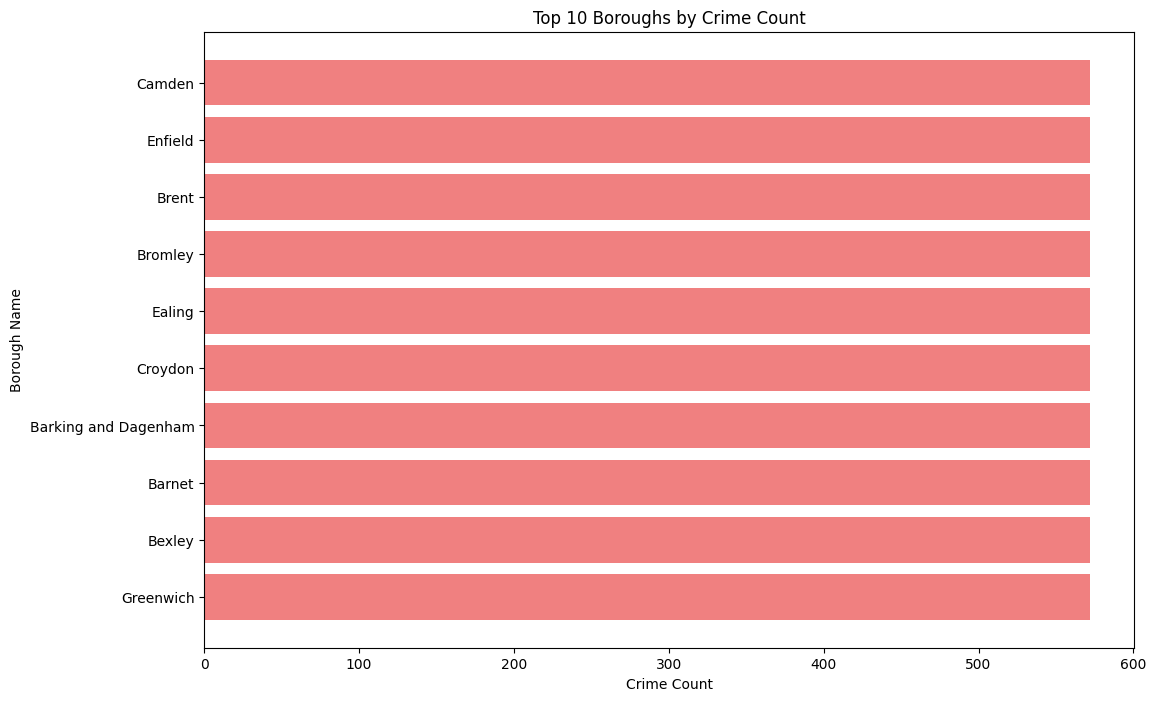

In [27]:
import matplotlib.pyplot as plt

# Query to get the relationship count between Boroughs and CrimeIncidents
query_relationship_check_borough = """
MATCH (b:Borough)-[:OCCURRED_AT]-(c:CrimeIncident)
RETURN b.name AS BoroughName, c.type AS CrimeType, count(c) AS CrimeCount
ORDER BY CrimeCount DESC
LIMIT 10
"""

# Execute the query and convert to DataFrame
result_relationship_check_borough = graph.run(query_relationship_check_borough).to_data_frame()

# Plot the data
plt.figure(figsize=(12, 8))
plt.barh(result_relationship_check_borough['BoroughName'], result_relationship_check_borough['CrimeCount'], color='lightcoral')
plt.xlabel('Crime Count')
plt.ylabel('Borough Name')
plt.title('Top 10 Boroughs by Crime Count')
plt.gca().invert_yaxis()
plt.show()


In [55]:
# Function to run and display query results
def run_query(query):
    return graph.run(query).data()

# Crimes by Type
query1 = """
MATCH (c:CrimeIncident)
RETURN c.type AS crime_type, COUNT(c) AS count
ORDER BY count DESC
"""
crimes_by_type = run_query(query1)
print("Crimes by Type:")
for record in crimes_by_type:
    print(record)

# Crimes by Location
query2 = """
MATCH (c:CrimeIncident)-[:OCCURRED_AT]->(b:Borough)
RETURN b.name AS borough, COUNT(c) AS count
ORDER BY count DESC
"""
crimes_by_location = run_query(query2)
print("Crimes by Location:")
for record in crimes_by_location:
    print(record)


Crimes by Type:
{'crime_type': 'THEFT', 'count': 19141}
{'crime_type': 'VEHICLE OFFENCES', 'count': 18312}
{'crime_type': 'PUBLIC ORDER OFFENCES', 'count': 14791}
{'crime_type': 'VIOLENCE AGAINST THE PERSON', 'count': 10788}
{'crime_type': 'SEXUAL OFFENCES', 'count': 9559}
{'crime_type': 'BURGLARY', 'count': 9552}
{'crime_type': 'DRUG OFFENCES', 'count': 9524}
{'crime_type': 'ARSON AND CRIMINAL DAMAGE', 'count': 9345}
{'crime_type': 'ROBBERY', 'count': 9337}
{'crime_type': 'MISCELLANEOUS CRIMES AGAINST SOCIETY', 'count': 4786}
{'crime_type': 'POSSESSION OF WEAPONS', 'count': 4776}
{'crime_type': 'FRAUD AND FORGERY', 'count': 1162}
Crimes by Location:
{'borough': 'Brent', 'count': 3756}
{'borough': 'Tower Hamlets', 'count': 3726}
{'borough': 'Newham', 'count': 3723}
{'borough': 'Lambeth', 'count': 3722}
{'borough': 'Ealing', 'count': 3720}
{'borough': 'Croydon', 'count': 3716}
{'borough': 'Greenwich', 'count': 3714}
{'borough': 'Enfield', 'count': 3709}
{'borough': 'Haringey', 'count': 

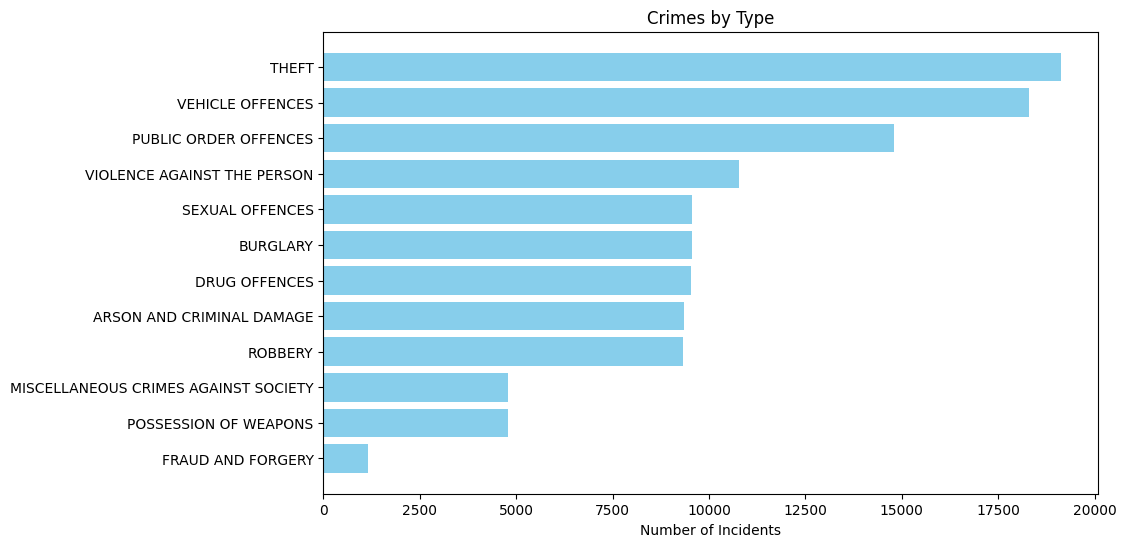

In [56]:
import matplotlib.pyplot as plt

# Data for Crimes by Type
crime_types = ['THEFT', 'VEHICLE OFFENCES', 'PUBLIC ORDER OFFENCES', 'VIOLENCE AGAINST THE PERSON', 'SEXUAL OFFENCES', 'BURGLARY', 'DRUG OFFENCES', 'ARSON AND CRIMINAL DAMAGE', 'ROBBERY', 'MISCELLANEOUS CRIMES AGAINST SOCIETY', 'POSSESSION OF WEAPONS', 'FRAUD AND FORGERY']
crime_counts = [19141, 18312, 14791, 10788, 9559, 9552, 9524, 9345, 9337, 4786, 4776, 1162]

plt.figure(figsize=(10, 6))
plt.barh(crime_types, crime_counts, color='skyblue')
plt.xlabel('Number of Incidents')
plt.title('Crimes by Type')
plt.gca().invert_yaxis()
plt.show()


In [39]:
# Load Borough Level Crime Data into Pandas DataFrame
borough_data = pd.read_csv('MPS Borough Level Crime (Historical).csv')

# Display the first few rows of the dataframe
print(borough_data.head())

# Display the column names of the dataframe
print(borough_data.columns)


                   MajorText                        MinorText  \
0  ARSON AND CRIMINAL DAMAGE                            ARSON   
1  ARSON AND CRIMINAL DAMAGE                  CRIMINAL DAMAGE   
2                   BURGLARY  BURGLARY BUSINESS AND COMMUNITY   
3                   BURGLARY           BURGLARY IN A DWELLING   
4              DRUG OFFENCES              POSSESSION OF DRUGS   

            BoroughName  201004  201005  201006  201007  201008  201009  \
0  Barking and Dagenham       6       5      11      10       6       6   
1  Barking and Dagenham     204     190     218     217     203     161   
2  Barking and Dagenham      48      58      58      46      46      51   
3  Barking and Dagenham     116     102     124     137     153     136   
4  Barking and Dagenham      76      64      82      72      98      87   

   201010  ...  202107  202108  202109  202110  202111  202112  202201  \
0      13  ...       3      12       5       7       5       1       3   
1     196 

## Ward

### Load Subset of Ward Data

In [13]:
from py2neo import Graph
import pandas as pd

# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12345678"))

# Add constraints for uniqueness
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (w:Ward) REQUIRE w.name IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (c:CrimeIncident) REQUIRE c.id IS UNIQUE")

# Function to load Ward data subset into Neo4j
def load_ward_data_subset(graph, file_path, row_limit=1000):
    data = pd.read_csv(file_path, nrows=row_limit)  # Load only a subset of rows
    for index, row in data.iterrows():
        # Create or merge Ward nodes
        location_query = f"""
        MERGE (w:Ward {{name: "{row['WardName'].replace('"', '\\"')}"}})
        ON CREATE SET w.borough = "{row['LookUp_BoroughName'].replace('"', '\\"')}"
        """
        graph.run(location_query)

        for year_month in data.columns[5:]:  # Adjust the starting index to match the data columns
            if row[year_month] > 0:
                # Create or merge CrimeIncident nodes and relationships
                crime_query = f"""
                MERGE (c:CrimeIncident {{id: "{row['WardName'].replace('"', '\\"')}_{year_month}_{row['MajorText'].replace('"', '\\"')}_{row['MinorText'].replace('"', '\\"')}"}})
                ON CREATE SET c.type = "{row['MajorText'].replace('"', '\\"')}", c.minor_type = "{row['MinorText'].replace('"', '\\"')}", c.date = '{year_month}', c.count = {row[year_month]}
                WITH c
                MATCH (w:Ward {{name: "{row['WardName'].replace('"', '\\"')}"}})
                MERGE (c)-[:OCCURRED_AT]->(w)
                """
                graph.run(crime_query)

# Load Ward Data subset into Neo4j
load_ward_data_subset(graph, 'MPS Ward Level Crime (Historical).csv', row_limit=1000)

# Verification queries
# Check Ward Nodes
print(graph.run("MATCH (w:Ward) RETURN w.name, w.borough LIMIT 25").data())

# Check CrimeIncident Nodes
print(graph.run("MATCH (c:CrimeIncident) RETURN c.id, c.type, c.date, c.count LIMIT 25").data())

# Check Relationships
print(graph.run("MATCH (w:Ward)-[:OCCURRED_AT]-(c:CrimeIncident) RETURN w.name, c.id LIMIT 25").data())


[{'w.name': 'Heathrow Villages', 'w.borough': 'Aviation Security (SO18)'}, {'w.name': 'Abbey', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Alibon', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Barking Riverside', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Beam', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Becontree', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Chadwell Heath', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Eastbrook & Rush Green', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Eastbury', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Gascoigne', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Goresbrook', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Heath', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Longbridge', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Mayesbrook', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Northbury', 'w.borough': 'Barking and Dagenham'}, {'w.name': 'Parsloes', 'w.borough': 'Barking 

## Verification Queries For Ward Data

In [17]:
# Import necessary libraries
import pandas as pd
from py2neo import Graph

# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12345678"))

# Verification Queries

# Query 1: Count of Wards
query_count_wards = """
MATCH (w:Ward)
RETURN count(w) AS NumberOfWards
"""

# Query 2: Count of CrimeIncidents
query_count_crimes = """
MATCH (c:CrimeIncident)
RETURN count(c) AS NumberOfCrimes
"""

# Query 3: Sample Data from Ward
query_sample_wards = """
MATCH (w:Ward)
RETURN w.name, w.borough
LIMIT 10
"""

# Query 4: Sample Data from CrimeIncident
query_sample_crimes = """
MATCH (c:CrimeIncident)
RETURN c.id, c.type, c.date, c.count
LIMIT 10
"""

# Query 5: Relationship Check between Ward and CrimeIncident
query_relationship_check = """
MATCH (w:Ward)<-[:OCCURRED_AT]-(c:CrimeIncident)
RETURN w.name, c.type, count(c) AS CrimeCount
ORDER BY CrimeCount DESC
LIMIT 10
"""

# Function to run queries and display results
def run_query(query):
    result = graph.run(query).to_data_frame()
    return result

# Run queries and display results
print("Count of Wards:")
print(run_query(query_count_wards))

print("\nCount of CrimeIncidents:")
print(run_query(query_count_crimes))

print("\nSample Data from Ward:")
print(run_query(query_sample_wards))

print("\nSample Data from CrimeIncident:")
print(run_query(query_sample_crimes))

print("\nRelationship Check between Ward and CrimeIncident:")
print(run_query(query_relationship_check))




Count of Wards:
   NumberOfWards
0             24

Count of CrimeIncidents:
   NumberOfCrimes
0           54464

Sample Data from Ward:
                   w.name                 w.borough
0       Heathrow Villages  Aviation Security (SO18)
1                   Abbey      Barking and Dagenham
2                  Alibon      Barking and Dagenham
3       Barking Riverside      Barking and Dagenham
4                    Beam      Barking and Dagenham
5               Becontree      Barking and Dagenham
6          Chadwell Heath      Barking and Dagenham
7  Eastbrook & Rush Green      Barking and Dagenham
8                Eastbury      Barking and Dagenham
9               Gascoigne      Barking and Dagenham

Sample Data from CrimeIncident:
                                                c.id  \
0  Heathrow Villages_202003_Arson and Criminal Da...   
1  Heathrow Villages_202003_Miscellaneous Crimes ...   
2         Heathrow Villages_202003_Theft_Other Theft   
3         Heathrow Villages_202003_

### Visualization Ward  

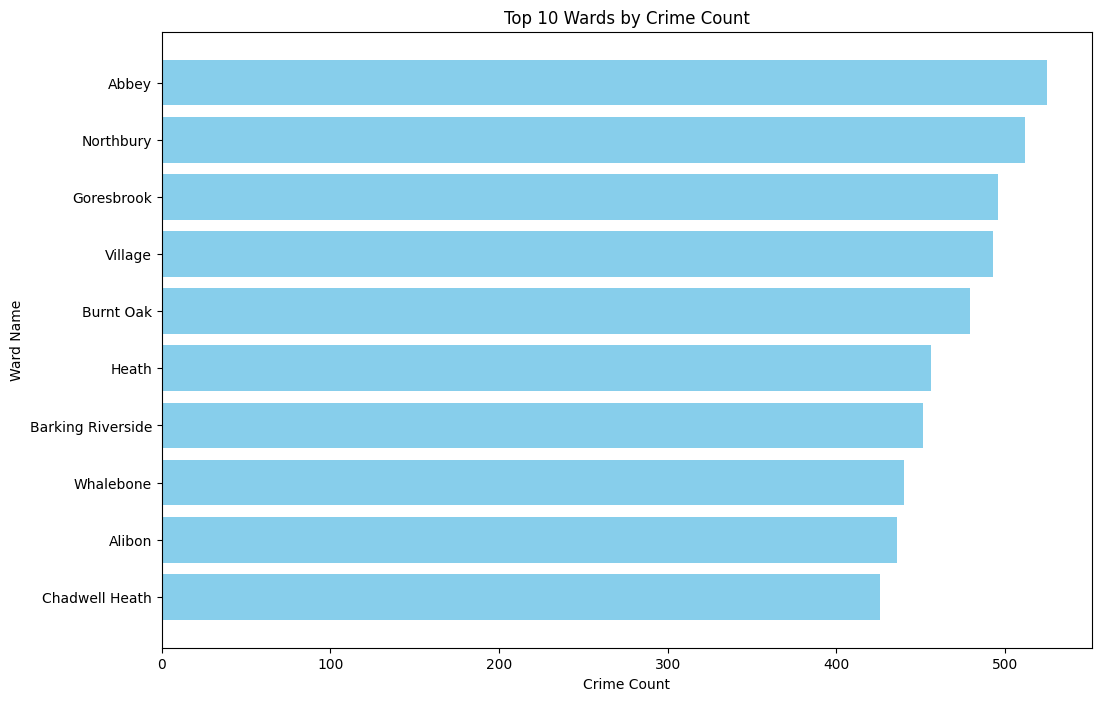

In [29]:
import matplotlib.pyplot as plt

# Query to get the relationship count between Wards and CrimeIncidents
query_relationship_check_ward = """
MATCH (w:Ward)-[:OCCURRED_AT]-(c:CrimeIncident)
RETURN w.name AS WardName, c.type AS CrimeType, count(c) AS CrimeCount
ORDER BY CrimeCount DESC
LIMIT 10
"""

# Execute the query and convert to DataFrame
result_relationship_check_ward = graph.run(query_relationship_check_ward).to_data_frame()

# Plot the data
plt.figure(figsize=(12, 8))
plt.barh(result_relationship_check_ward['WardName'], result_relationship_check_ward['CrimeCount'], color='skyblue')
plt.xlabel('Crime Count')
plt.ylabel('Ward Name')
plt.title('Top 10 Wards by Crime Count')
plt.gca().invert_yaxis()
plt.show()


# Documentation of the process Ward
documentation = """
## Neo4j Data Import and Verification

### Steps Followed:

1. **Data Import**:
   - Imported Ward data using a subset of rows to ensure manageability.
   - Created uniqueness constraints on Ward and CrimeIncident nodes.

2. **Verification**:
   - Ran queries to verify the number of nodes and relationships.
   - Checked sample data from Ward and CrimeIncident nodes.
   - Verified relationships between Ward and CrimeIncident nodes.

### Queries Used:

1. **Count of Wards**:
```cypher
MATCH (w:Ward)
RETURN count(w) AS NumberOfWards

In [59]:
# Inspect the first few rows of the Ward CSV file
ward_data = pd.read_csv('MPS Ward Level Crime (Historical).csv')
print(ward_data.head())
print(ward_data.columns)

# Inspect the first few rows of the LSOA CSV file
lsoa_data = pd.read_csv('MPS LSOA Level Crime (Historical).csv')
print(lsoa_data.head())
print(lsoa_data.columns)


            WardName   WardCode                             MajorText  \
0  Heathrow Villages  E05013570             Arson and Criminal Damage   
1  Heathrow Villages  E05013570  Miscellaneous Crimes Against Society   
2  Heathrow Villages  E05013570                                 Theft   
3  Heathrow Villages  E05013570                                 Theft   
4  Heathrow Villages  E05013570                      Vehicle Offences   

                    MinorText        LookUp_BoroughName  201004  201005  \
0             Criminal Damage  Aviation Security (SO18)       0       0   
1   Other Notifiable Offences  Aviation Security (SO18)       0       0   
2                 Other Theft  Aviation Security (SO18)       0       0   
3                 Shoplifting  Aviation Security (SO18)       0       0   
4  Theft from a Motor Vehicle  Aviation Security (SO18)       0       0   

   201006  201007  201008  ...  202104  202105  202106  202107  202108  \
0       0       0       0  ...      

In [19]:
import pandas as pd

# Load the CSV file and display its column names
file_path = 'MPS LSOA Level Crime (Historical).csv'
data = pd.read_csv(file_path, nrows=5)
print(data.columns)


Index(['LSOA Code', 'LSOA Name', 'Borough', 'Major Category', 'Minor Category',
       '201903', '201904', '201905', '201906', '201907',
       ...
       '202102', '202103', '202104', '202105', '202106', '202107', '202108',
       '202109', '202110', '202111'],
      dtype='object', length=145)


## Load LSOA Data

In [21]:
# Import necessary libraries
import pandas as pd
from py2neo import Graph

# Function to connect to Neo4j
def connect_to_neo4j(uri, user, password):
    try:
        graph = Graph(uri, auth=(user, password))
        return graph
    except Exception as e:
        print("Error connecting to Neo4j:", e)
        return None

# Connect to Neo4j
graph = connect_to_neo4j("bolt://localhost:7687", "neo4j", "12345678")

# Function to load LSOA data into Neo4j
def load_lsoa_data(graph, file_path, row_limit=1000):
    data = pd.read_csv(file_path, nrows=row_limit)  # Load only a subset of rows
    for index, row in data.iterrows():
        # Update these column names based on your CSV file
        lsoa_code = row['LSOA Code']
        lsoa_name = row['LSOA Name']
        borough_name = row['Borough']
        
        # Create or merge LSOA nodes
        lsoa_query = f"""
        MERGE (l:LSOA {{code: "{lsoa_code}"}})
        ON CREATE SET l.name = "{lsoa_name.replace('"', '\\"')}", l.borough = "{borough_name.replace('"', '\\"')}"
        """
        graph.run(lsoa_query)

        for year_month in data.columns[5:]:  # Adjust the starting index to match the data columns
            if row[year_month] > 0:
                # Create or merge CrimeIncident nodes and relationships
                crime_query = f"""
                MERGE (c:CrimeIncident {{id: "{lsoa_code}_{year_month}_{row['Major Category'].replace('"', '\\"')}_{row['Minor Category'].replace('"', '\\"')}"}})
                ON CREATE SET c.type = "{row['Major Category'].replace('"', '\\"')}", c.minor_type = "{row['Minor Category'].replace('"', '\\"')}", c.date = '{year_month}', c.count = {row[year_month]}
                WITH c
                MATCH (l:LSOA {{code: "{lsoa_code}"}})
                MERGE (c)-[:OCCURRED_AT]->(l)
                """
                graph.run(crime_query)

# Add constraints for uniqueness
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (l:LSOA) REQUIRE l.code IS UNIQUE")
graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (c:CrimeIncident) REQUIRE c.id IS UNIQUE")

# Load LSOA Data into Neo4j
load_lsoa_data(graph, 'MPS LSOA Level Crime (Historical).csv')


## Verification Queries For Lsoa Data

In [22]:
# Query 1: Count of LSOAs
query_count_lsoas = """
MATCH (l:LSOA)
RETURN count(l) AS NumberOfLSOAs
"""

# Query 2: Sample Data from LSOA
query_sample_lsoas = """
MATCH (l:LSOA)
RETURN l.code, l.name, l.borough
LIMIT 10
"""

# Query 3: Relationship Check between LSOA and CrimeIncident
query_relationship_check_lsoa = """
MATCH (l:LSOA)<-[:OCCURRED_AT]-(c:CrimeIncident)
RETURN l.name, c.type, count(c) AS CrimeCount
ORDER BY CrimeCount DESC
LIMIT 10
"""

# Function to run queries and display results
def run_query(query):
    result = graph.run(query).to_data_frame()
    return result

# Run queries and display results
print("Count of LSOAs:")
print(run_query(query_count_lsoas))

print("\nSample Data from LSOA:")
print(run_query(query_sample_lsoas))

print("\nRelationship Check between LSOA and CrimeIncident:")
print(run_query(query_relationship_check_lsoa))


Count of LSOAs:
   NumberOfLSOAs
0             32

Sample Data from LSOA:
      l.code                     l.name  l.borough
0  E01000006  Barking and Dagenham 016A  E09000002
1  E01000007  Barking and Dagenham 015A  E09000002
2  E01000008  Barking and Dagenham 015B  E09000002
3  E01000009  Barking and Dagenham 016B  E09000002
4  E01000011  Barking and Dagenham 016C  E09000002
5  E01000012  Barking and Dagenham 015D  E09000002
6  E01000013  Barking and Dagenham 013A  E09000002
7  E01000014  Barking and Dagenham 013B  E09000002
8  E01000015  Barking and Dagenham 009A  E09000002
9  E01000016  Barking and Dagenham 009B  E09000002

Relationship Check between LSOA and CrimeIncident:
                      l.name                       c.type  CrimeCount
0  Barking and Dagenham 013A                        Theft         399
1  Barking and Dagenham 015A                        Theft         381
2  Barking and Dagenham 002B                        Theft         285
3  Barking and Dagenham 016B     

### Visualization Lsoa

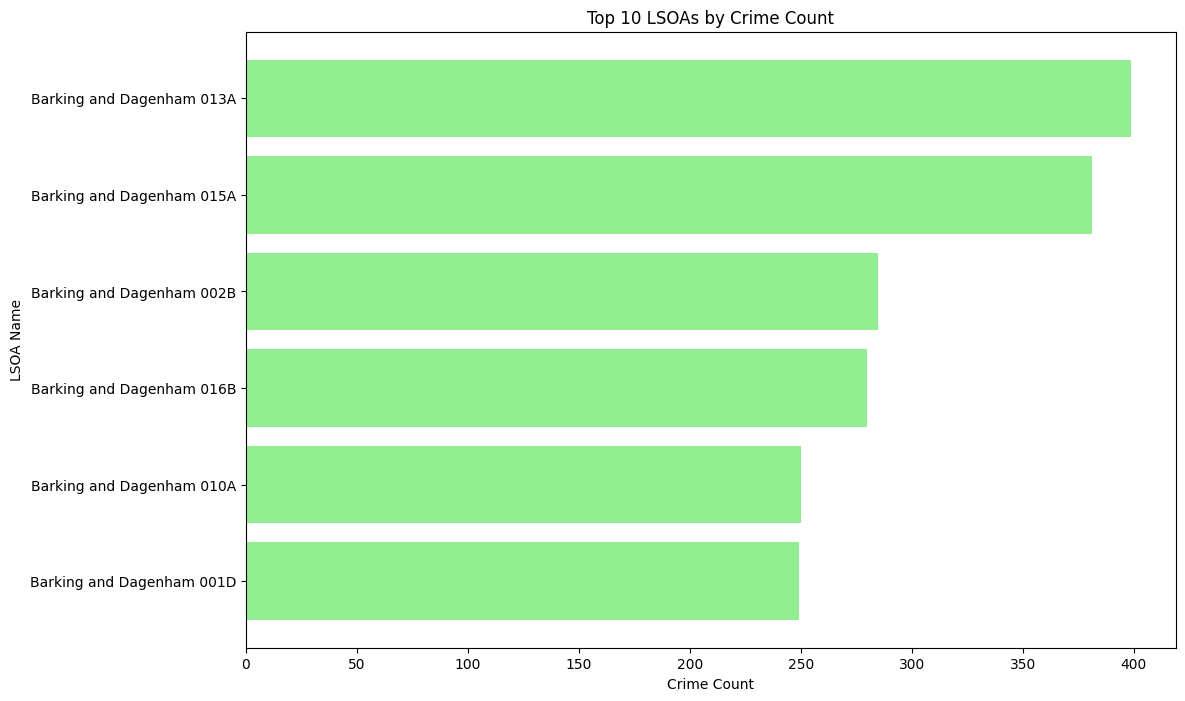

In [30]:
import matplotlib.pyplot as plt

# Query to get the relationship count between LSOAs and CrimeIncidents
query_relationship_check_lsoa = """
MATCH (l:LSOA)-[:OCCURRED_AT]-(c:CrimeIncident)
RETURN l.name AS LSOAName, c.type AS CrimeType, count(c) AS CrimeCount
ORDER BY CrimeCount DESC
LIMIT 10
"""

# Execute the query and convert to DataFrame
result_relationship_check_lsoa = graph.run(query_relationship_check_lsoa).to_data_frame()

# Plot the data
plt.figure(figsize=(12, 8))
plt.barh(result_relationship_check_lsoa['LSOAName'], result_relationship_check_lsoa['CrimeCount'], color='lightgreen')
plt.xlabel('Crime Count')
plt.ylabel('LSOA Name')
plt.title('Top 10 LSOAs by Crime Count')
plt.gca().invert_yaxis()
plt.show()


# Documentation of the process LSOA
documentation = """
## Neo4j Data Import and Verification

### Steps Followed:

1. **Data Import**:
   - Imported LSOA data using a subset of rows to ensure manageability.
   - Created uniqueness constraints on LSOA and CrimeIncident nodes.

2. **Verification**:
   - Ran queries to verify the number of nodes and relationships.
   - Checked sample data from LSOA nodes.
   - Verified relationships between LSOA and CrimeIncident nodes.

### Queries Used:

1. **Count of LSOAs**:
```cypher
MATCH (l:LSOA)
RETURN count(l) AS NumberOfLSOAs